In [29]:
# Import necessary libraries
from datetime import datetime, timedelta
import requests
from io import BytesIO

# pandas and matplotlib for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# geopandas and h3 libraries for spatial data processing
import geopandas as gpd
import h3
import h3pandas
from shapely.geometry import Point,LineString
import contextily as cx

# R5Py for travel time matrix computation
from r5py import TransportNetwork, TravelTimeMatrixComputer

# NetworkX for percolation analysis
import networkx as nx

## Prepare datasets
### Create spatial tessellation of Shenzhen using H3

In [ ]:
# URL to download the GeoJSON file for the second-level administrative boundaries in China
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_CHN_2.json"

# Download the GeoJSON file
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Load the GeoJSON data into a GeoDataFrame
gdf = gpd.read_file(BytesIO(response.content))

# Filter for Shenzhen, Guangdong
shenzhen_boundary = gdf[(gdf['NAME_1'] == 'Guangdong') & (gdf['NAME_2'] == 'Shenzhen')]
shenzhen_boundary = shenzhen_boundary.to_crs('EPSG:4547') # Change it to local projection

# Display the GeoDataFrame
# print(shenzhen_boundary)

# Plot the boundary
shenzhen_boundary.plot()

In [13]:
# shenzhen_boundary = gpd.read_file('shenzhen_boundary.geojson',crs='EPSG:4547')

# Setting level for H3 grid
h3_level = 8

# Generate hexagons within the boundary use h3pandas
shenzhen_hexagons = shenzhen_boundary.h3.polyfill_resample(h3_level)

# Drop the generated index column and reset the index
shenzhen_hexagons.drop(columns=['index'], inplace=True)
shenzhen_hexagons = shenzhen_hexagons.reset_index(drop=False)

# shenzhen_hexagons.plot()

print('Number of hexagons:', len(shenzhen_hexagons))

# gla_hexagons.to_file('gla_hexagons.geojson', driver='GeoJSON')

Number of hexagons: 2677


### Load OSM data

## Calculate Accessibility

In [14]:
# Calculate centroids only once and use it for both origins and destinations
centroids = shenzhen_hexagons.centroid

# Create a single GeoDataFrame and set the CRS in the same step
origins_destinations = gpd.GeoDataFrame({'id': shenzhen_hexagons['h3_polyfill'], 'geometry': centroids}, crs=shenzhen_hexagons.crs)

# Since both origins and destinations are identical, clone the dataframe
origins = origins_destinations.copy()
destinations = origins_destinations.copy()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_52332/1931993152.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = shenzhen_hexagons.centroid


In [15]:
# Create a transport network object
transport_network = TransportNetwork(
    "r5/shenzhen.osm.pbf",
    []#No public transport data
)

In [16]:
travel_time_computer = TravelTimeMatrixComputer(transport_network,
                                                origins=origins, destinations=destinations,
                                                #snap_to_network=True,
                                                transport_modes=['WALK','BICYCLE'],
                                                max_time=timedelta(minutes=60)
                                                )

In [17]:
time_matrix = travel_time_computer.compute_travel_times()
# print(time_matrix.head())

In [65]:
# Build an OD matrix with generated time matrix

od_matrix = time_matrix.copy()

od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='from_id', right_on='id', suffixes=('', '_from'))
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='to_id', right_on='id', suffixes=('_from', '_to'))

# od_matrix.head()

In [66]:
# Filter rows where travel_time is not NaN
valid_od_matrix = od_matrix[~od_matrix['travel_time'].isna()].copy()

# Create LineStrings from the valid rows
valid_od_matrix['geometry'] = valid_od_matrix.apply(lambda row: LineString([row['geometry_from'], row['geometry_to']]), axis=1)

# Convert to GeoDataFrame
od_lines = gpd.GeoDataFrame(valid_od_matrix, geometry='geometry')

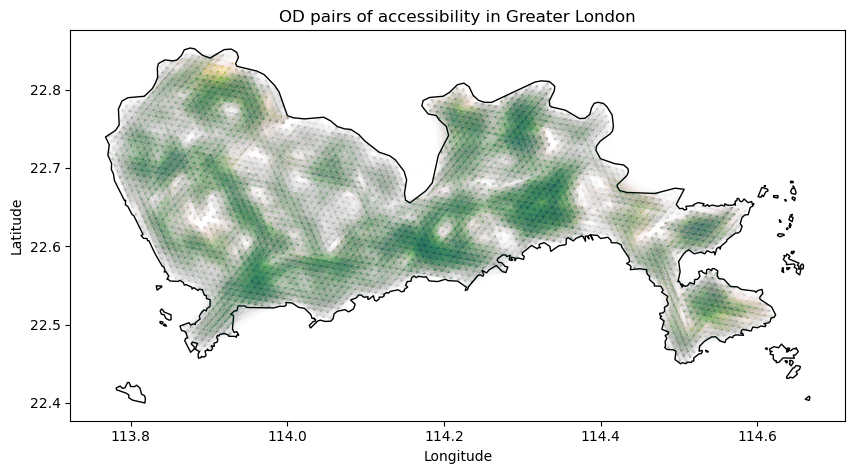

In [20]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the GLA boundary for context
shenzhen_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the OD lines on the same axes
od_lines.plot(ax=ax, column = "travel_time", scheme='natural_breaks', alpha=0.002)

# Optional: Add labels, title, or grid
ax.set_title('OD pairs of accessibility in Shenzhen')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## Load Bike Sharing Data

In [21]:
gdf_og = gpd.read_file('/Users/silver/Desktop/Connect/20240500-Bike_Shenzhen/OD_adj_cleaned.geojson')

In [22]:
gdf = gdf_og.drop(columns=['Geometry','Start Lat','Start Lng','End Lat','End Lng'])

# Exclude the trips that have larger than 20km/h speed
gdf['Speed'] = gdf['Distance (km)'] / gdf['Duration (minutes)'] * 60
gdf = gdf[gdf['Speed'] <= 20]

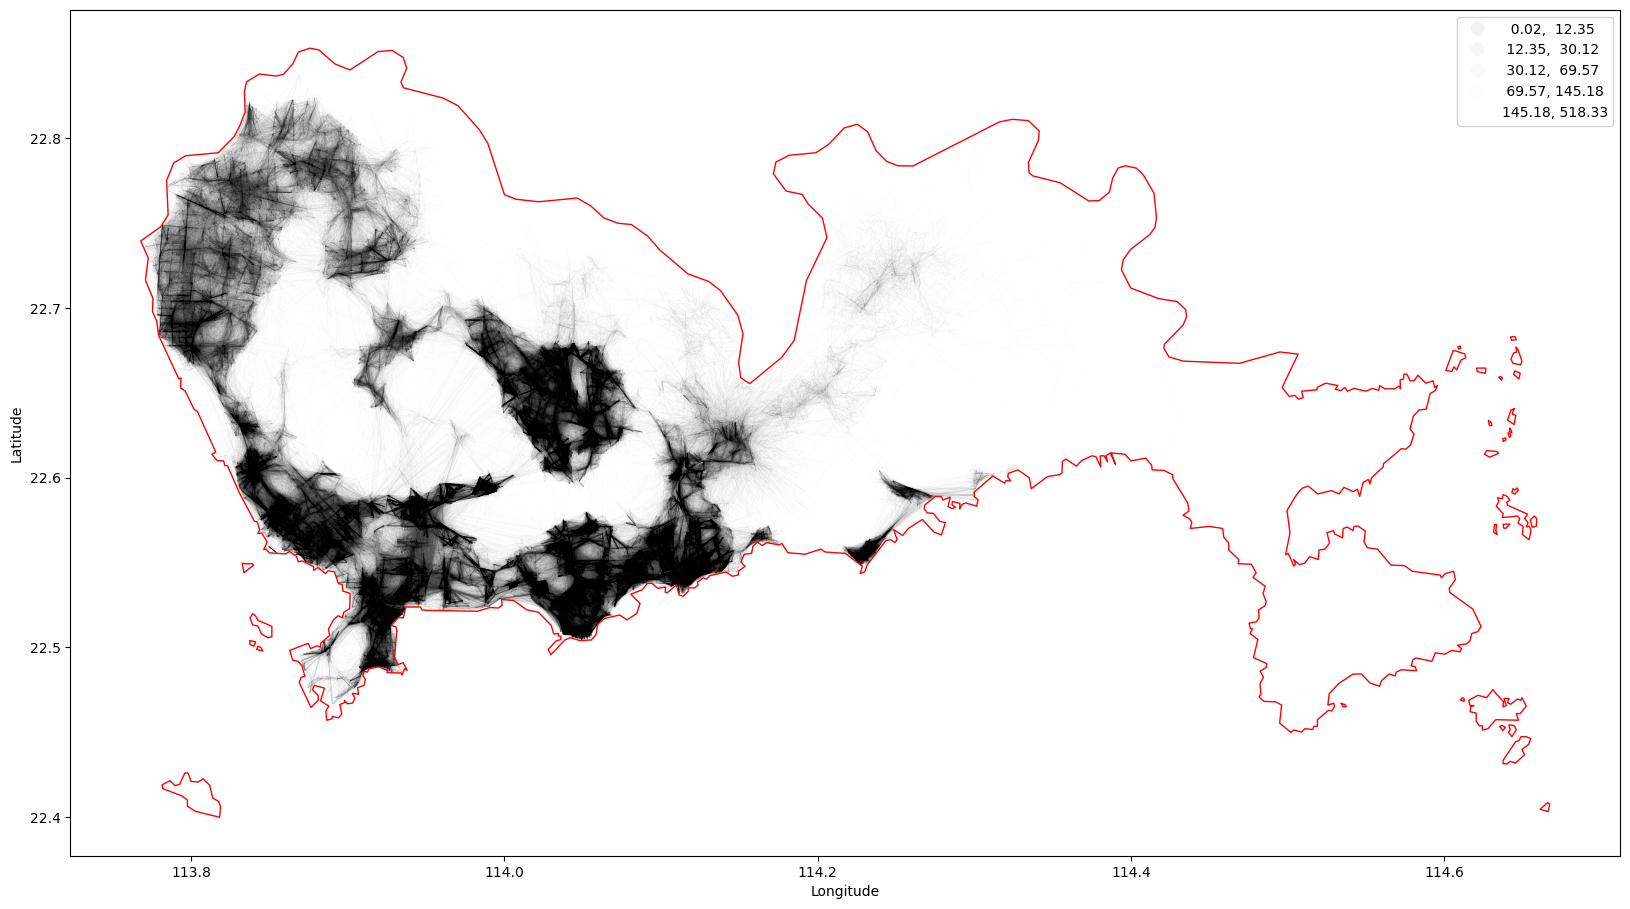

In [23]:
# Plotting the main GeoDataFrame
ax = gdf.plot(
    column='Duration (minutes)',
    legend=True,
    figsize=(20, 12),
    scheme='NaturalBreaks',
    k=5,
    cmap='Greys_r',
    alpha=0.05,
    linewidth=0.2
)

# Adding the boundary overlay
shenzhen_boundary.boundary.plot(ax=ax, color='red', linewidth=1)

# Adding titles and labels if necessary
#plt.title('Mobility Data with Shenzhen Boundary Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [57]:
def compute_od_matrix_from_trips(trips_gdf, hexgrid_gdf):
    """
    Compute the OD matrix directly from trip data and a hexagonal grid.
    
    Parameters:
    trips_gdf (GeoDataFrame): The trips GeoDataFrame containing 'geometry' of LineStrings.
    hexgrid_gdf (GeoDataFrame): The hexagonal grid GeoDataFrame containing 'geometry' of hexagons.
    
    Returns:
    DataFrame: The OD matrix with trip counts between hexagons.
    """
    # Ensure CRS is consistent
    if trips_gdf.crs != hexgrid_gdf.crs:
        trips_gdf = trips_gdf.to_crs(hexgrid_gdf.crs)

    # Compute the start and end points of each trip
    trips_gdf['start_point'] = trips_gdf.geometry.apply(lambda geom: Point(geom.coords[0]))
    trips_gdf['end_point'] = trips_gdf.geometry.apply(lambda geom: Point(geom.coords[-1]))

    # Match start and end points to hexagons
    start_hexagons = gpd.sjoin(trips_gdf.set_geometry('start_point'), hexgrid_gdf, how='left', op='within')
    #print(start_hexagons.head())
    start_hexagons = start_hexagons.rename(columns={'h3_polyfill': 'start_hex'})

    end_hexagons = gpd.sjoin(trips_gdf.set_geometry('end_point'), hexgrid_gdf, how='left', op='within')
    end_hexagons = end_hexagons.rename(columns={'h3_polyfill': 'end_hex'})

    # Combine start and end hexagon information into one DataFrame
    trips_hex = pd.merge(start_hexagons[['Travel ID', 'start_hex']],
                         end_hexagons[['Travel ID', 'end_hex']],
                         on='Travel ID')

    # Compute the OD matrix of hexagons
    od_matrix = trips_hex.groupby(['start_hex', 'end_hex']).size().reset_index(name='trip_count')
    
    
    return od_matrix


In [67]:
trip_od = compute_od_matrix_from_trips(gdf, shenzhen_hexagons)

trip_od = pd.merge(trip_od, origins_destinations, how='left', left_on='start_hex', right_on='id', suffixes=('', '_from'))
trip_od = pd.merge(trip_od, origins_destinations, how='left', left_on='end_hex', right_on='id', suffixes=('_from', '_to'))

valid_trip = trip_od[~trip_od['trip_count'].isna()].copy()

/Users/silver/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/silver/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
# Create LineStrings from the valid rows
valid_trip['geometry'] = valid_trip.apply(lambda row: LineString([row['geometry_from'], row['geometry_to']]), axis=1)

# Convert to GeoDataFrame
trip_matrix = gpd.GeoDataFrame(valid_trip, geometry='geometry')

In [71]:
trip_matrix

,start_hex,end_hex,trip_count,id_from,geometry_from,id_to,geometry_to,geometry
0,88411c0001fffff,88411c005dfffff,1,88411c0001fffff,POINT (114.23688 22.75576),88411c005dfffff,POINT (114.23825 22.73380),"LINESTRING (114.23688 22.75576, 114.23825 22.7..."
1,88411c0001fffff,88411c028dfffff,1,88411c0001fffff,POINT (114.23688 22.75576),88411c028dfffff,POINT (114.20826 22.71049),"LINESTRING (114.23688 22.75576, 114.20826 22.7..."
2,88411c0001fffff,88411c02adfffff,1,88411c0001fffff,POINT (114.23688 22.75576),88411c02adfffff,POINT (114.21556 22.73082),"LINESTRING (114.23688 22.75576, 114.21556 22.7..."
3,88411c0003fffff,88411c0009fffff,1,88411c0003fffff,POINT (114.22820 22.75739),88411c0009fffff,POINT (114.24023 22.74789),"LINESTRING (114.22820 22.75739, 114.24023 22.7..."
4,88411c0003fffff,88411c001dfffff,1,88411c0003fffff,POINT (114.22820 22.75739),88411c001dfffff,POINT (114.22287 22.75115),"LINESTRING (114.22820 22.75739, 114.22287 22.7..."
...,...,...,...,...,...,...,...,...
43157,88411cb9bdfffff,88411cb9b7fffff,14,88411cb9bdfffff,POINT (114.10443 22.54157),88411cb9b7fffff,POINT (114.09239 22.55107),"LINESTRING (114.10443 22.54157, 114.09239 22.5..."
43158,88411cb9bdfffff,88411cb9b9fffff,54,88411cb9bdfffff,POINT (114.10443 22.54157),88411cb9b9fffff,POINT (114.09910 22.53532),"LINESTRING (114.10443 22.54157, 114.09910 22.5..."
43159,88411cb9bdfffff,88411cb9bbfffff,26,88411cb9bdfffff,POINT (114.10443 22.54157),88411cb9bbfffff,POINT (114.09042 22.53694),"LINESTRING (114.10443 22.54157, 114.09042 22.5..."
43160,88411cb9bdfffff,88411cb9bdfffff,925,88411cb9bdfffff,POINT (114.10443 22.54157),88411cb9bdfffff,POINT (114.10443 22.54157),"LINESTRING (114.10443 22.54157, 114.10443 22.5..."


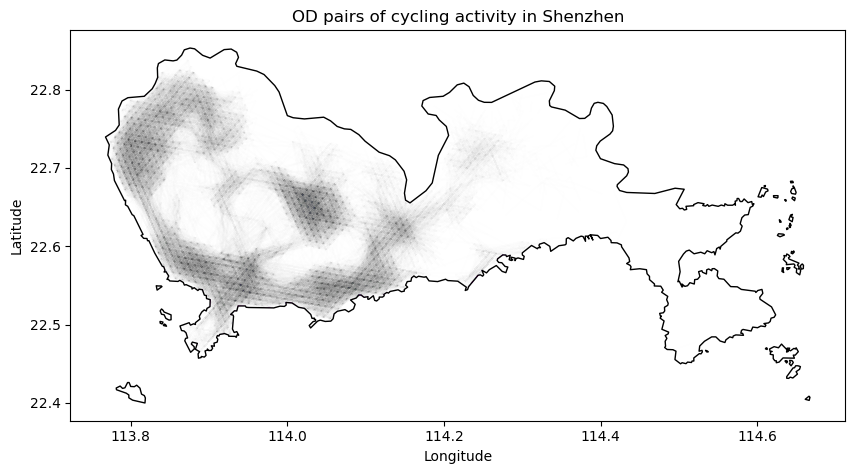

In [72]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the GLA boundary for context
shenzhen_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the OD lines on the same axes
trip_matrix.plot(ax=ax, column = "trip_count", scheme='natural_breaks', alpha=0.005)

# Optional: Add labels, title, or grid
ax.set_title('OD pairs of cycling activity in Shenzhen')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## Percolation Analysis

In [73]:
def percolation_clustering(connections_gdf, time_threshold):
    """
    Apply percolation clustering on the connections GeoDataFrame.
    
    Parameters:
    connections_gdf (GeoDataFrame): GeoDataFrame containing lines representing the connections.
    trip_count_threshold (int): Threshold value for trip_count to filter connections.
    
    Returns:
    GeoDataFrame: Filtered and clustered connections GeoDataFrame with cluster IDs.
    """
    # Step 1: Filter connections based on the trip_count threshold
    filtered_connections = connections_gdf[connections_gdf['travel_time'] <= time_threshold].copy()

    # Step 2: Create a graph from the filtered connections
    G = nx.Graph()
    for idx, row in filtered_connections.iterrows():
        start_point = row.geometry.coords[0]
        end_point = row.geometry.coords[1]
        G.add_edge(start_point, end_point, trip_count=row['travel_time'])

    # Step 3: Identify clusters from the graph
    clusters = list(nx.connected_components(G))
    clusters_sorted = sorted(clusters, key=len, reverse=True)

    # Step 4: Assign cluster IDs to the connections
    cluster_map = {}
    for cluster_id, cluster in enumerate(clusters_sorted):
        for node in cluster:
            cluster_map[node] = cluster_id

    filtered_connections.loc[:, 'cluster_id'] = filtered_connections.apply(
        lambda row: cluster_map[row.geometry.coords[0]], axis=1)

    return filtered_connections

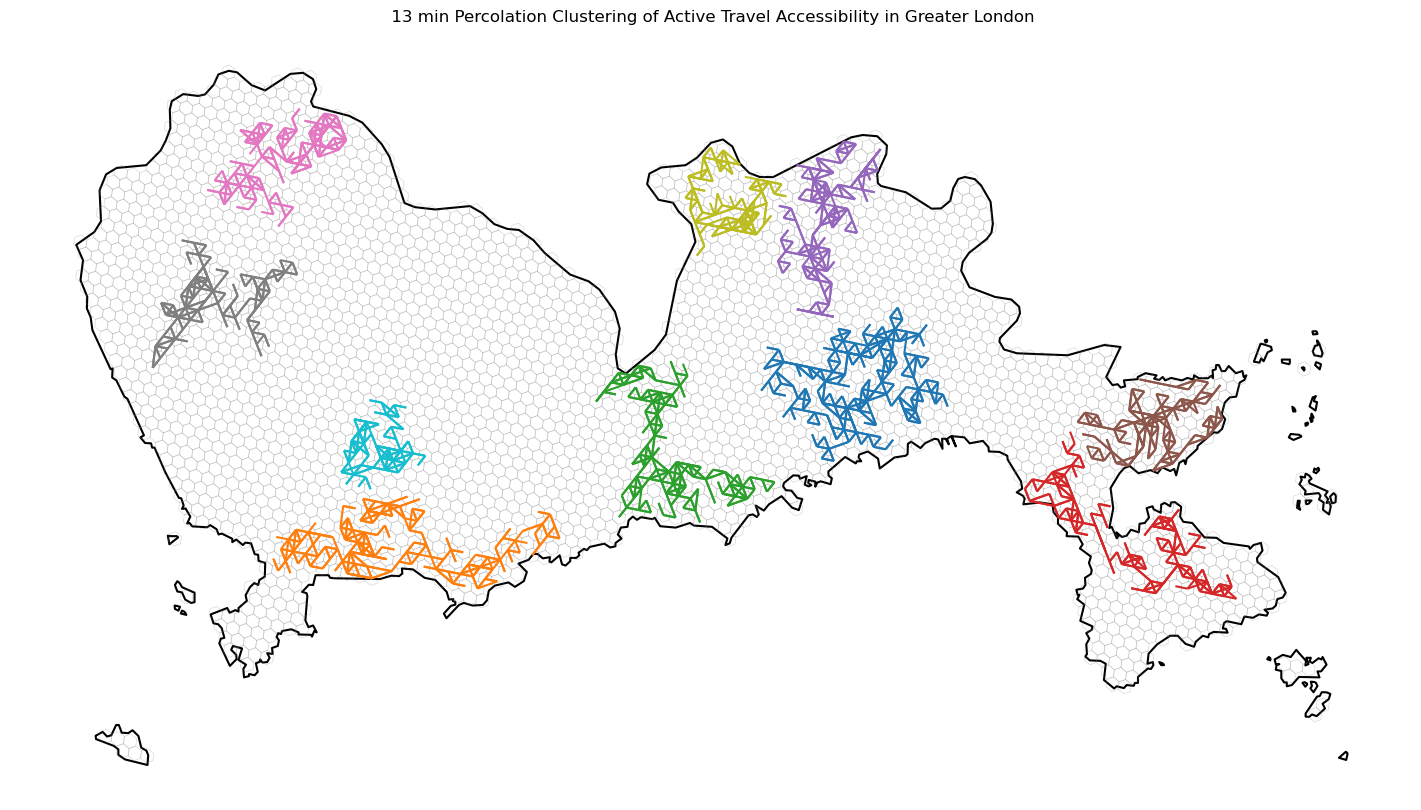

In [82]:
time_threshold = 13

clustered_gdf = percolation_clustering(valid_od_matrix, time_threshold)

# Identify the largest 10 clusters
top_clusters = clustered_gdf['cluster_id'].value_counts().nlargest(10).index

# Filter the connections to include only the largest 10 clusters
top_clustered_gdf = clustered_gdf[clustered_gdf['cluster_id'].isin(top_clusters)]
top_clustered_gdf = gpd.GeoDataFrame(top_clustered_gdf, geometry='geometry', crs=origins_destinations.crs)

# Visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the boundary in the background
shenzhen_boundary.boundary.plot(ax=ax, edgecolor='black')
shenzhen_hexagons.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5,alpha=0.3)

# Plot the clustered connections
top_clustered_gdf.plot(ax=ax, column='cluster_id', linewidth=1.5, legend=False, cmap='tab10')

plt.title(f' {time_threshold} min Percolation Clustering of Active Travel Accessibility in Greater London')
plt.axis('off')
plt.show()

In [76]:
def percolation_trip_clustering(connections_gdf, trip_threshold):
    """
    Apply percolation clustering on the connections GeoDataFrame.
    
    Parameters:
    connections_gdf (GeoDataFrame): GeoDataFrame containing lines representing the connections.
    trip_count_threshold (int): Threshold value for trip_count to filter connections.
    
    Returns:
    GeoDataFrame: Filtered and clustered connections GeoDataFrame with cluster IDs.
    """
    # Step 1: Filter connections based on the trip_count threshold
    filtered_connections = connections_gdf[connections_gdf['trip_count'] >= trip_threshold].copy()

    # Step 2: Create a graph from the filtered connections
    G = nx.Graph()
    for idx, row in filtered_connections.iterrows():
        start_point = row.geometry.coords[0]
        end_point = row.geometry.coords[1]
        G.add_edge(start_point, end_point, trip_count=row['trip_count'])

    # Step 3: Identify clusters from the graph
    clusters = list(nx.connected_components(G))
    clusters_sorted = sorted(clusters, key=len, reverse=True)

    # Step 4: Assign cluster IDs to the connections
    cluster_map = {}
    for cluster_id, cluster in enumerate(clusters_sorted):
        for node in cluster:
            cluster_map[node] = cluster_id

    filtered_connections.loc[:, 'cluster_id'] = filtered_connections.apply(
        lambda row: cluster_map[row.geometry.coords[0]], axis=1)

    return filtered_connections

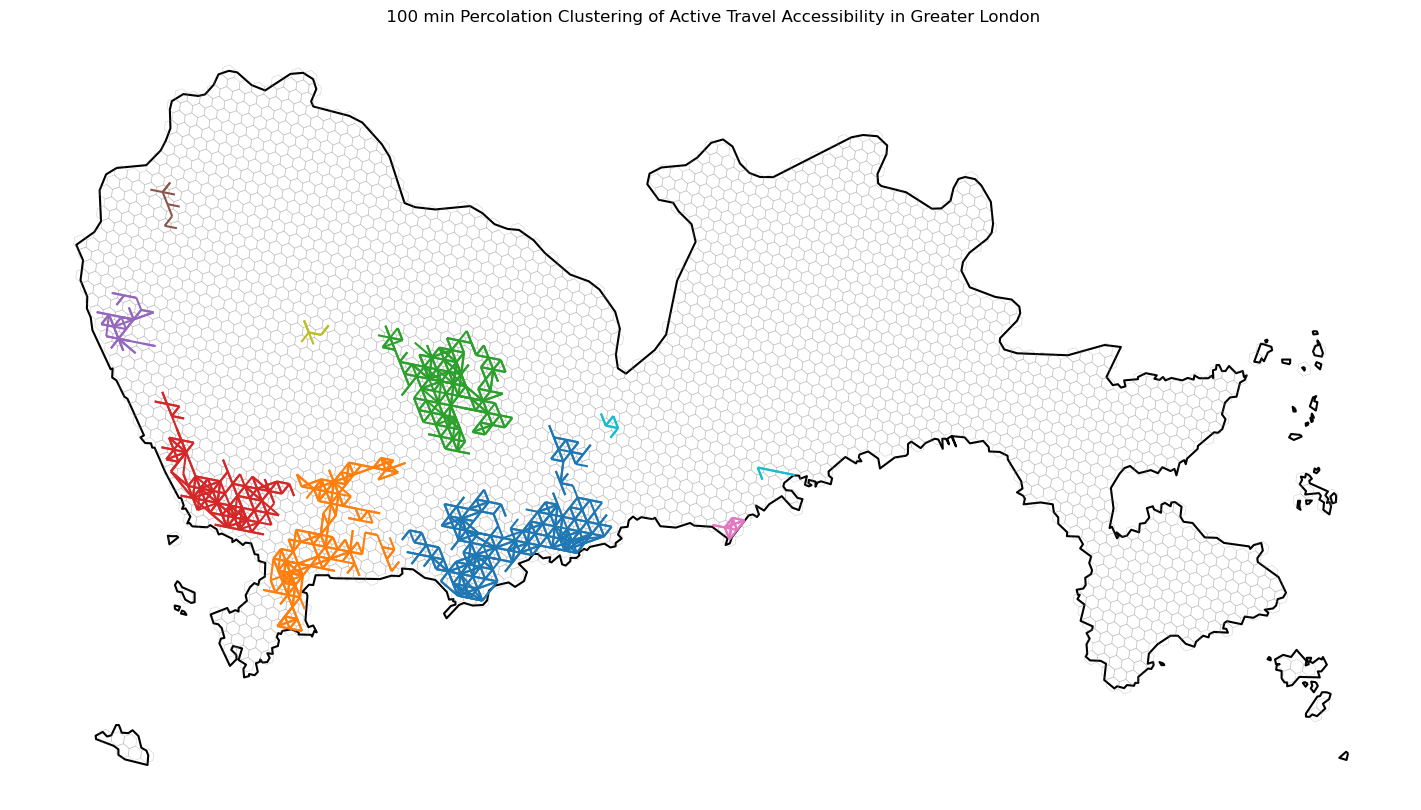

In [79]:
trip_threshold = 100

clustered_gdf = percolation_trip_clustering(trip_matrix, trip_threshold)

# Identify the largest 10 clusters
top_clusters = clustered_gdf['cluster_id'].value_counts().nlargest(10).index

# Filter the connections to include only the largest 10 clusters
top_clustered_gdf = clustered_gdf[clustered_gdf['cluster_id'].isin(top_clusters)]
top_clustered_gdf = gpd.GeoDataFrame(top_clustered_gdf, geometry='geometry', crs=origins_destinations.crs)

# Visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the boundary in the background
shenzhen_boundary.boundary.plot(ax=ax, edgecolor='black')
shenzhen_hexagons.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5,alpha=0.3)

# Plot the clustered connections
top_clustered_gdf.plot(ax=ax, column='cluster_id', linewidth=1.5, legend=False, cmap='tab10')

plt.title(f' {trip_threshold} Percolation Clustering of Active Travel Accessibility in Greater London')
plt.axis('off')
plt.show()